# 08. Milestone Project 2: PyTorch Paper Replicating

The goal of machine learning research paper replicating is: Turn a ML research paper into usable code.

In this notebook, we're going to be replicating the Vision Transformer (ViT) architecture/paper with PyTorch: https://arxiv.org/pdf/2010.11929

See ground truth notebook here: https://www.learnpytorch.io/08_pytorch_paper_replicating/#08-pytorch-paper-replicating

## 0. Get setup

Let's import code we've previously written + required libraries.

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.4.1+cu121
torchvision version: 0.19.1+cu121


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (321/321), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 4356 (delta 213), reused 254 (delta 178), pack-reused 4035 (from 1)
Receiving objects: 100% (4356/4356), 654.51 MiB | 20.98 MiB/s, done.
Resolving deltas: 100% (2585/2585), done.
Updating files: 100% (248/248), done.


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

The whole goal of what we're trying to do is to replicate the ViT architecture for our FoodVision Mini problem.

To do that, we need some data.

Namely, the pizza, steak and sushi images we've been using so far.

In [ ]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

In [ ]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224  # comes from Table 3 of the ViT paper

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [ ]:
# Create a batch size of 32 (the paper uses 4096 but this may be too big for our smaller hardware... can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3. Visualize a single image

As always, let's adhere to the motto, *visualize, visualize, visualize*!

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[5], label_batch[5]

# View the single image and label shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

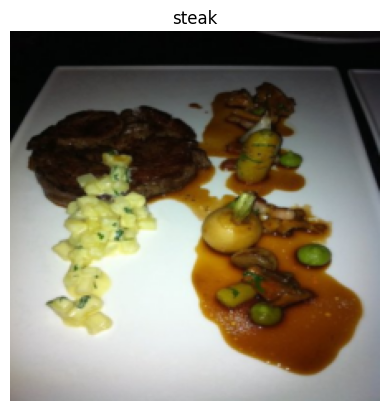

In [ ]:
# Plot the image with matplotlib
import matplotlib.pyplot as plt

plt.imshow(image.permute(1, 2, 0))  # (color_channels, height, width) -> (height, width, color_channels)
plt.title(class_names[label])
plt.axis(False);

## 3. Replicating ViT: Overview

Looking at a whole machine learning research paper can be intimidating.

So in order to make it more understandable, we can break it down into smaller pieces.

* **Inputs** - What goes into the model? (in our case, image tensors).
* **Outputs** - What comes out of the model/layer/block? (in our case, we want the model to output image classification labels).
* **Layers** - Takes an input, manipulates it with a function (for example could be self-attention).
* **Blocks** - A collection of layers.
* **Model (or architecture)** - A collection of blocks.

### 3.1. ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture.
* Four equations: Math equations which define the functions of each layer/block.
* Table 1/3: Different hyperparameters for the architecture/training.
* Text.

### Figure 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-figure-1-architecture-overview.png?raw=true)

* Embedding = Learnable representation (start with random numbers and improve over time).

### Four equations

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-four-equations.png?raw=true)

#### Section 3.1 describes the various equations:

**Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

**Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudocode:

```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```

---

**Equations 2&3:**
The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudocode:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block
```
---

**Equation 4:**
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_{L}^{0}$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP = multilayer perceptron = a neural network with X number of layers
* MLP = one hidden layer at training time
* MLP = single linear layer at fine-tuning time

In pseudocode:

```python
# Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

### Table 1

![](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/08-vit-paper-table-1.png?raw=true)

* ViT-Base, ViT-Large and ViT-Huge are all different sizes of the same model architecture
* ViT-B/16 = ViT-Base with image patch size 16x16
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Heads - the number of multi-head self-attention

## 4. Equation 1: Split data into pathces and creating the class, position and patch embedding

Layers = input -> function -> output

What's the input shape?

What's the output shape?

* Input shape: (224, 224, 3) -> single image -> (height, width, color channels)
* Output shape:

> **Equation 1:**
An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle $2 \mathrm{D}$ images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened $2 \mathrm{D}$ patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

> **Equation 1:**
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable $1 \mathrm{D}$ position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

* Input shape: $H\times{W}\times{C}$ (height x width x color channels)
* Output shape: ${N \times\left(P^{2} \cdot C\right}}$
* H = height
* W = width
* C = color channels
* P = patch size
* N = number of patches = (height * width) / p^2
* D = constant latent vector size = embedding dimension (see Table 1)

In [ ]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / patch_size**2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)
